## **Taller 1**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

## Carga de librerías

In [78]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

In [79]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


(222, 4)


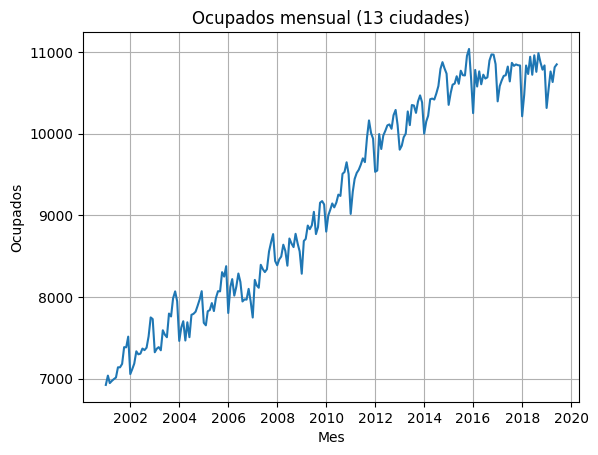

In [80]:
# Tamaño del dataframe
print(data.shape)

# Graficar los datos
plt.title("Ocupados mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

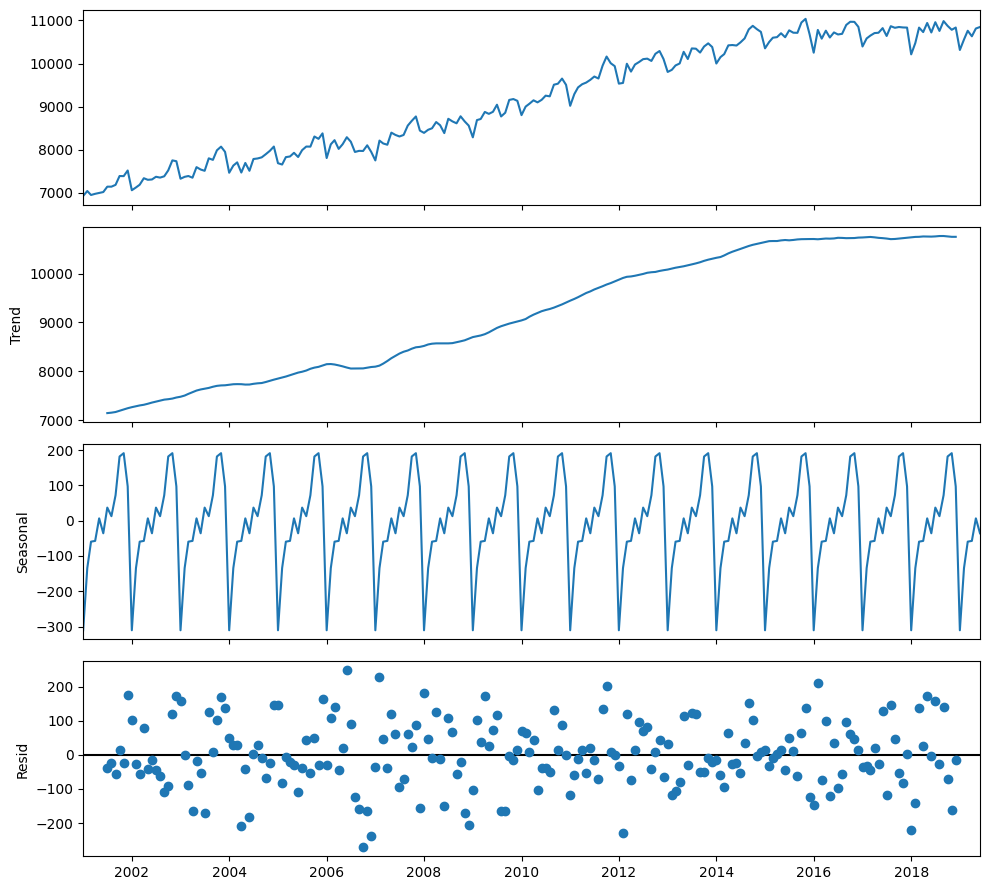

In [81]:
td_componentes = seasonal_decompose(data[["Ocupados"]],model="aditive")
fig = td_componentes.plot()
fig.set_size_inches((10, 9))
fig.tight_layout()
plt.show()

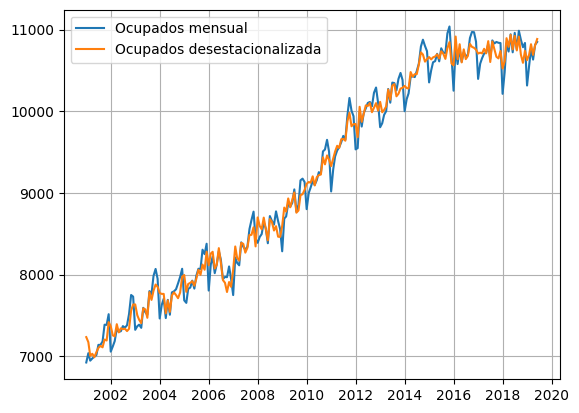

In [82]:
td_desestacionalizada = data["Ocupados"]-td_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Ocupados mensual")
plt.plot(td_desestacionalizada,label="Ocupados desestacionalizada")
plt.legend()
plt.grid()
plt.show()

## **4. Pronosticando metodos de suavización**

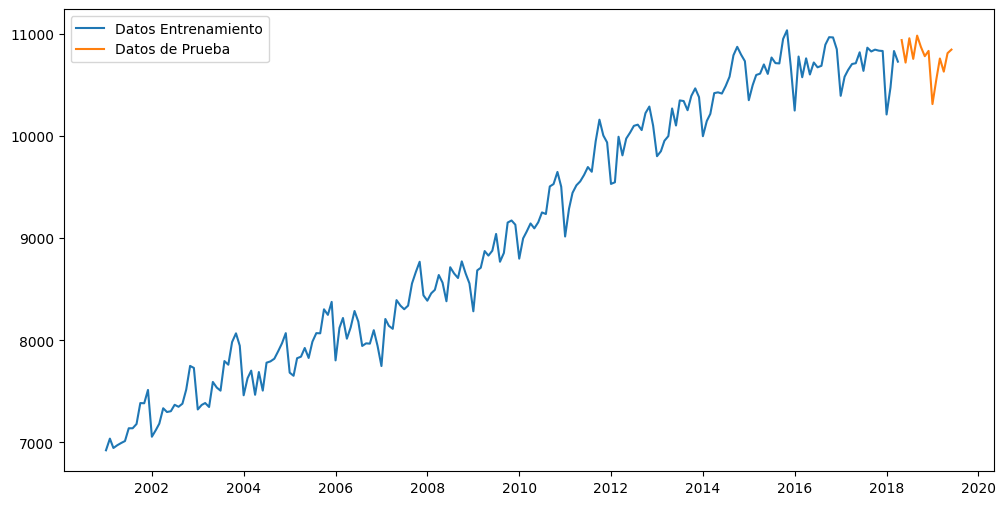

In [83]:
train_len = 208
train_td = data[["Ocupados"]][:train_len]
test_td = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

In [84]:
## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()

In [85]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [86]:
ma_2_f= fore_ma(train_td,2,12)
ma_3_f= fore_ma(train_td,3,12)
ma_4_f= fore_ma(train_td,4,12)
ma_5_f= fore_ma(train_td,5,12)

In [87]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td[:12],ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td[:12],ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td[:12],ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td[:12],ma_5_f ))

In [88]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

180.61405651284463 190.8075001193029 218.76010738130725 221.86244433696749


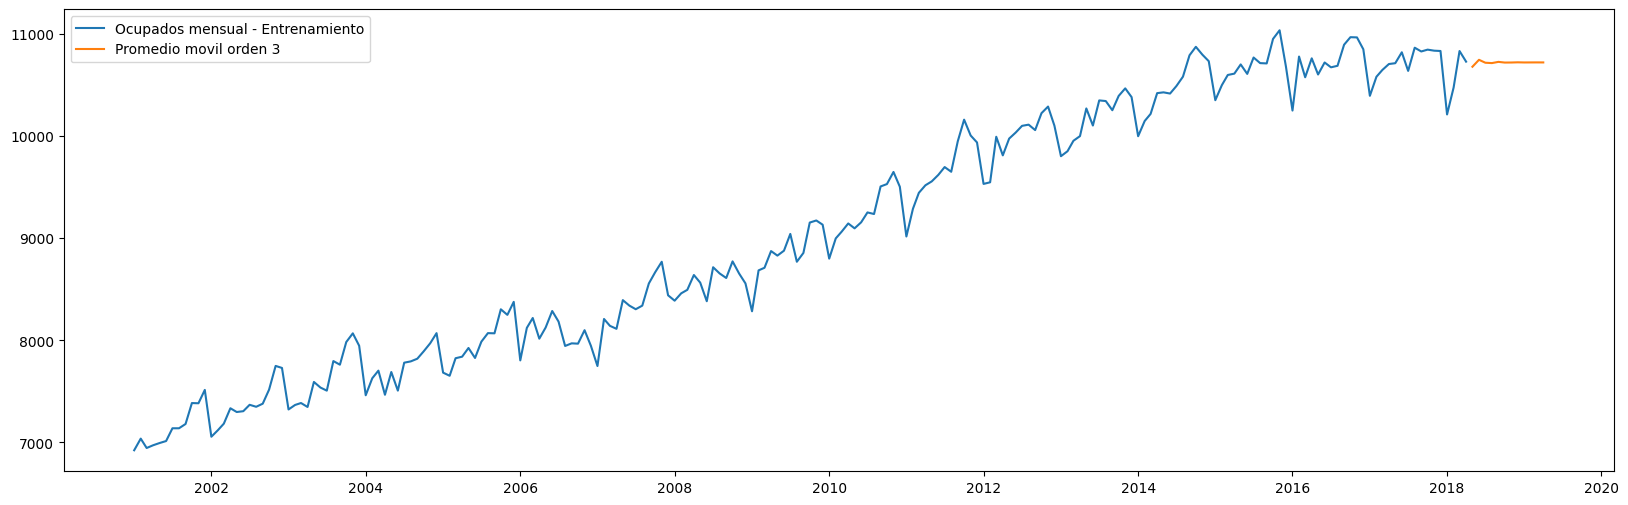

In [89]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Ocupados mensual - Entrenamiento")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend()
plt.show()

### **4.2 Suavizacion Exponencial Simple**

In [90]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast      lower_95      upper_95
2018-05-01    10720.369526  10363.683813  11077.055240
2018-06-01    10720.369526  10295.289553  11145.449500
2018-07-01    10720.369526  10236.467399  11204.271654
2018-08-01    10720.369526  10184.058465  11256.680587
2018-09-01    10720.369526  10136.333706  11304.405347
2018-10-01    10720.369526  10092.224539  11348.514513
2018-11-01    10720.369526  10051.015801  11389.723252
2018-12-01    10720.369526  10012.200976  11428.538077
2019-01-01    10720.369526   9975.405782  11465.333271
2019-02-01    10720.369526   9940.344356  11500.394696
2019-03-01    10720.369526   9906.792516  11533.946536
2019-04-01    10720.369526   9874.570593  11566.168460


c:\Users\ALEXANDER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


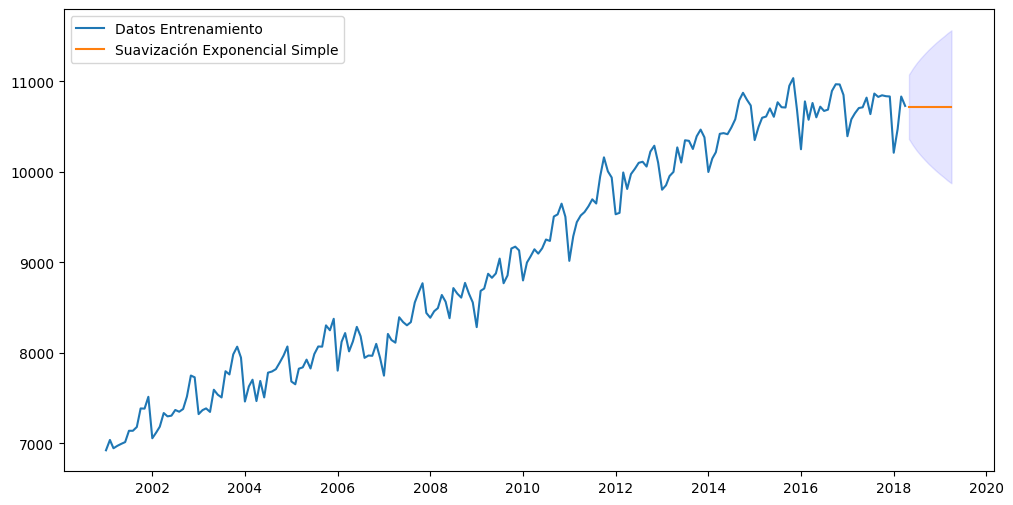

In [91]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [92]:
ets_result.alpha

np.float64(0.6482796866258126)

In [93]:
rmse = np.sqrt(mean_squared_error(test_td[:12],point_forecast ))
print(rmse)

186.78634558232417


### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [94]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast      lower_95      upper_95
2018-05-01    10749.538825  10294.293963  11185.437410
2018-06-01    10773.218913  10304.410307  11268.715655
2018-07-01    10796.951166  10268.718006  11344.134319
2018-08-01    10820.735699  10250.004989  11455.234385
2018-09-01    10844.572627  10197.020440  11509.392241
2018-10-01    10868.462065  10220.061346  11603.002876
2018-11-01    10892.404128  10230.762351  11592.243472
2018-12-01    10916.398934  10136.276430  11707.492489
2019-01-01    10940.446597  10173.860452  11766.621576
2019-02-01    10964.547235  10144.791124  11876.425190
2019-03-01    10988.700964  10148.450342  11915.702889
2019-04-01    11012.907901  10169.406809  11984.591628


c:\Users\ALEXANDER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


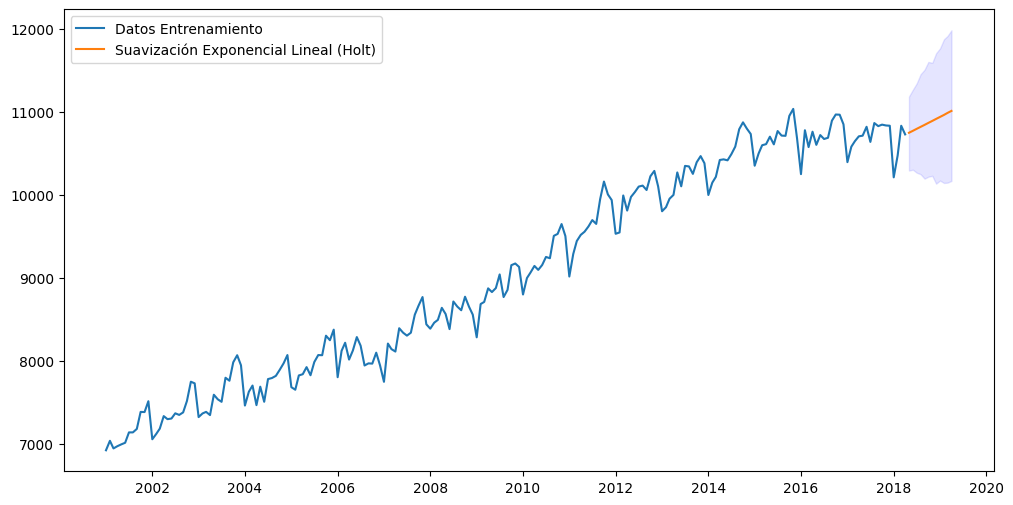

In [95]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [96]:
print(ets_result.alpha,ets_result.beta)

0.5619343685836977 5.619343685836977e-05


In [97]:
rmse_holt = np.sqrt(mean_squared_error(test_td[:12],preds_holt['Point_forecast']))
print(rmse_holt)

268.07488513326774


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [98]:
# Build model
ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast      lower_95      upper_95
2018-05-01    10778.693831  10522.795803  11034.591859
2018-06-01    10842.441207  10571.495210  11113.387204
2018-07-01    10833.170337  10547.966460  11118.374215
2018-08-01    10942.105206  10643.320408  11240.890004
2018-09-01    10997.495290  10685.718054  11309.272527
2018-10-01    11095.849060  10771.597120  11420.101000
2018-11-01    11114.796845  10778.530310  11451.063380
2018-12-01    11011.820263  10663.951565  11359.688960
2019-01-01    10524.729944  10165.631538  10883.828350
2019-02-01    10802.750553  10432.760976  11172.740130
2019-03-01    10952.750130  10572.178855  11333.321404
2019-04-01    10962.102529  10571.233894  11352.971163


c:\Users\ALEXANDER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


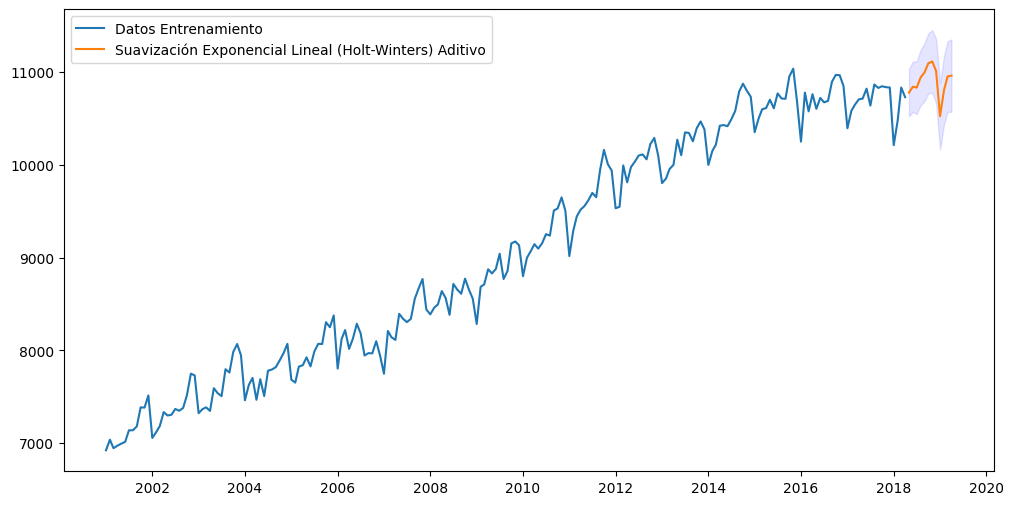

In [99]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [100]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.3479121635419951 3.4791216354199516e-05 0.3222910502092631


In [101]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td[:12],preds_hw_add['Point_forecast']))
print(rmse_hw_add)

210.48306826963457


In [106]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2018-05-01    10787.445260  10544.993484  11004.169186
2018-06-01    10757.065453  10464.079080  11005.055130
2018-07-01    10832.086254  10503.000635  11128.393851
2018-08-01    10816.529648  10480.516104  11127.613040
2018-09-01    10878.550583  10486.868123  11237.070615
2018-10-01    11021.781053  10619.706448  11410.726315
2018-11-01    11036.623599  10603.201571  11439.068112
2018-12-01    10910.527748  10477.307318  11333.699269
2019-01-01    10434.469849  10015.333931  10861.061160
2019-02-01    10638.037707  10189.787850  11068.797480
2019-03-01    10721.751779  10214.735556  11168.663541
2019-04-01    10730.726129  10230.335452  11215.632008


c:\Users\ALEXANDER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


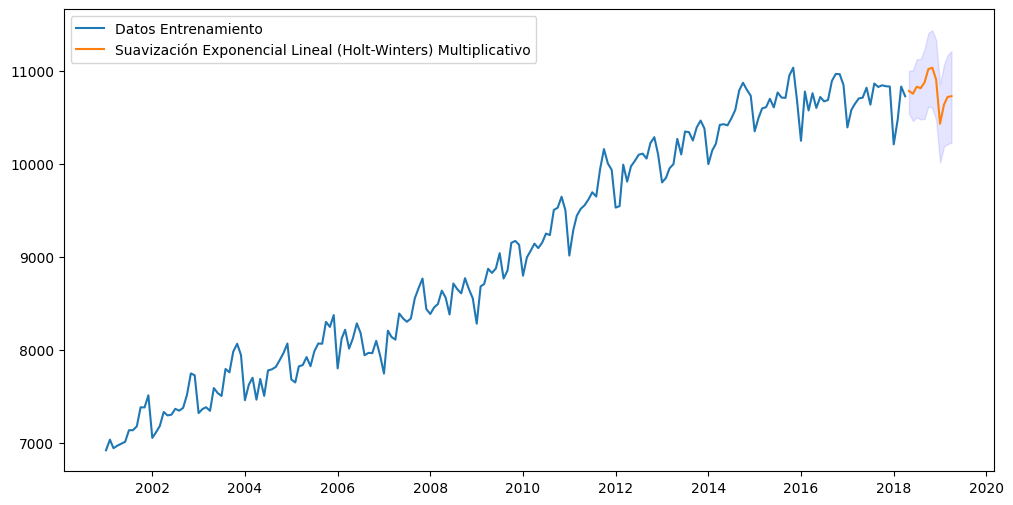

In [107]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [108]:
print(ets_result.alpha,ets_result.gamma)

0.6067557454538809 3.9324425454611915e-05


In [109]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_td,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

ValueError: Found input variables with inconsistent numbers of samples: [14, 12]